In [51]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns


In [52]:

# 1. Feature Extraction
def extract_features(file_path):
    signal, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
    print(f"Extracted MFCCs for {file_path} with shape: {mfccs.shape}")  # Debugging line
    mfccs = mfccs.T  # Shape: (time_steps, 13 features)
    mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)  # Normalize
    return mfccs


In [53]:
# Data Augmentation Function
def augment_data(signal, sr):
    # Add random noise
    noise = np.random.randn(len(signal))
    signal_noisy = signal + 0.005 * noise

    # Random pitch shifting
    pitch_shifted = librosa.effects.pitch_shift(signal, sr, n_steps=np.random.randint(-2, 2))

    # Random time stretching
    stretched = librosa.effects.time_stretch(signal, rate=np.random.uniform(0.9, 1.1))

    # Randomly apply augmentations
    augmentations = [signal, signal_noisy, pitch_shifted, stretched]
    return augmentations

In [54]:

# 2. Dataset Loading
def load_dataset(dataset_path):
    features = []
    labels = []
    print(f"Dataset path: {dataset_path}")  # Debugging line
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                print(f"Processing file: {file_path}")  # Debugging line
                try:
                    mfccs = extract_features(file_path)
                    emotion = int(file.split("-")[2]) - 1  # Zero-indexing
                    features.append(mfccs)
                    labels.append(emotion)
                except Exception as e:
                    print(f"Skipped {file}: {e}")
    print(f"Number of files processed: {len(features)}")  # Debugging line
    return features, labels


In [55]:
dataset_path = r"archive"  # Make sure the path is correct
X, y = load_dataset(dataset_path)

# Check if the dataset was loaded correctly
print(f"Features (X) length: {len(X)}")
print(f"Labels (y) length: {len(y)}")

# If no features are found, the previous code will stop
if len(X) == 0:
    raise ValueError("No features were extracted. Please check the dataset path or feature extraction process.")


Dataset path: archive
Processing file: archive\Actor_01\03-01-01-01-01-01-01.wav
Extracted MFCCs for archive\Actor_01\03-01-01-01-01-01-01.wav with shape: (13, 143)
Processing file: archive\Actor_01\03-01-01-01-01-02-01.wav
Extracted MFCCs for archive\Actor_01\03-01-01-01-01-02-01.wav with shape: (13, 144)
Processing file: archive\Actor_01\03-01-01-01-02-01-01.wav
Extracted MFCCs for archive\Actor_01\03-01-01-01-02-01-01.wav with shape: (13, 141)
Processing file: archive\Actor_01\03-01-01-01-02-02-01.wav
Extracted MFCCs for archive\Actor_01\03-01-01-01-02-02-01.wav with shape: (13, 137)
Processing file: archive\Actor_01\03-01-02-01-01-01-01.wav
Extracted MFCCs for archive\Actor_01\03-01-02-01-01-01-01.wav with shape: (13, 153)
Processing file: archive\Actor_01\03-01-02-01-01-02-01.wav
Extracted MFCCs for archive\Actor_01\03-01-02-01-01-02-01.wav with shape: (13, 156)
Processing file: archive\Actor_01\03-01-02-01-02-01-01.wav
Extracted MFCCs for archive\Actor_01\03-01-02-01-02-01-01.wav

In [56]:

# Convert labels to NumPy array
y = np.array(y)

# Pad sequences to same length
max_length = max(x.shape[0] for x in X)
X_padded = np.array([np.pad(x, ((0, max_length - x.shape[0]), (0, 0)), mode='constant') for x in X])

In [57]:

# 4. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)


In [58]:


# 5. Build Model
model = Sequential([
    Conv1D(256, 5, activation='relu', input_shape=(max_length, 13), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(3),
    Dropout(0.3),
    Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(8, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\joywi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:

# 6. Train with Validation Split
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
]

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)


Epoch 1/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8620 - loss: 0.7113 - val_accuracy: 0.8460 - val_loss: 0.7734 - learning_rate: 1.0000e-04
Epoch 2/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8661 - loss: 0.6980 - val_accuracy: 0.8547 - val_loss: 0.8036 - learning_rate: 1.0000e-04
Epoch 3/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8817 - loss: 0.6596 - val_accuracy: 0.8698 - val_loss: 0.7272 - learning_rate: 1.0000e-04
Epoch 4/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8591 - loss: 0.7215 - val_accuracy: 0.8308 - val_loss: 0.8036 - learning_rate: 1.0000e-04
Epoch 5/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9017 - loss: 0.6085 - val_accuracy: 0.8633 - val_loss: 0.7471 - learning_rate: 1.0000e-04
Epoch 6/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8899 - loss: 0.6365 - val_accuracy: 0.8243 - val_loss: 0.8115 - learning_rate: 1.0000e-04
Epoch 7/300
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8851 - loss: 0.3415

Test Accuracy: 87.50%


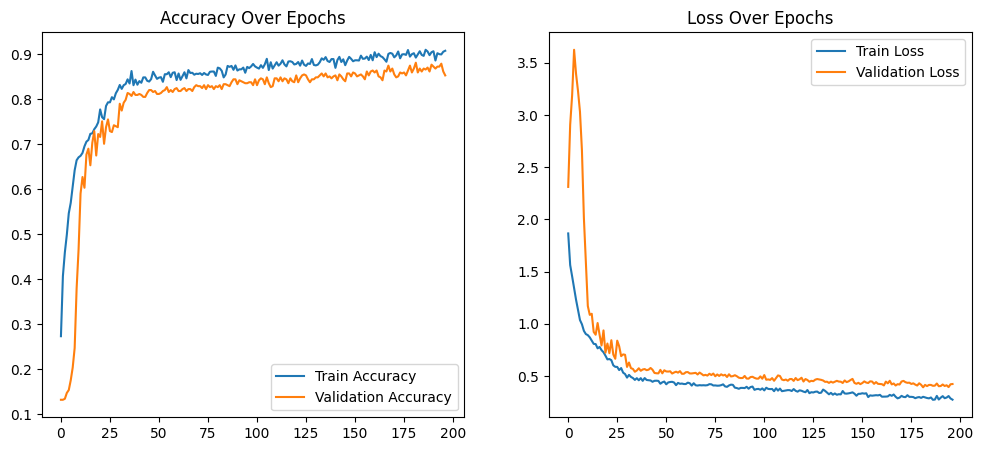

In [ ]:

# 7. Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


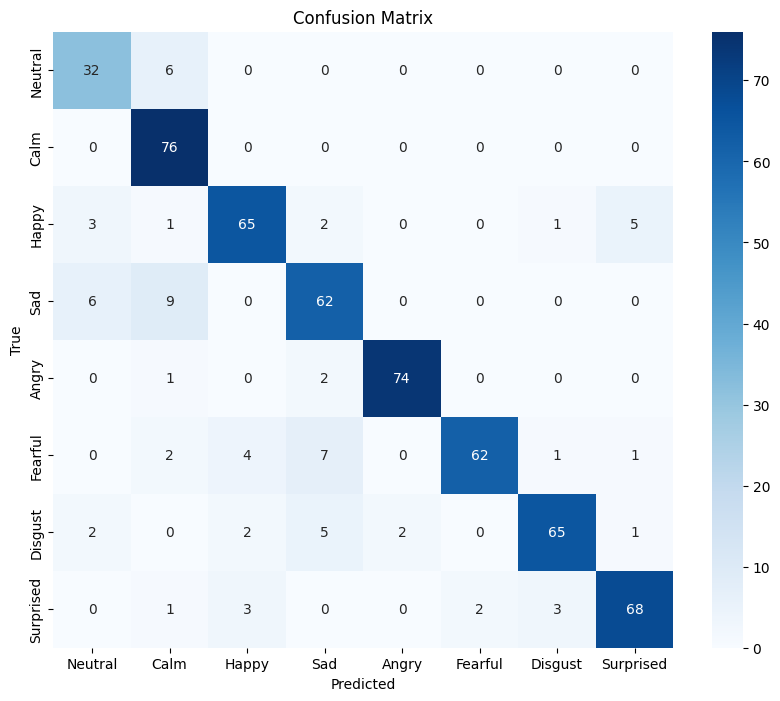

              precision    recall  f1-score   support

     Neutral       0.74      0.84      0.79        38
        Calm       0.79      1.00      0.88        76
       Happy       0.88      0.84      0.86        77
         Sad       0.79      0.81      0.80        77
       Angry       0.97      0.96      0.97        77
     Fearful       0.97      0.81      0.88        77
     Disgust       0.93      0.84      0.88        77
   Surprised       0.91      0.88      0.89        77

    accuracy                           0.88       576
   macro avg       0.87      0.87      0.87       576
weighted avg       0.88      0.88      0.88       576



In [ ]:

# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Neutral", "Calm", "Happy", "Sad", 
                        "Angry", "Fearful", "Disgust", "Surprised"],
            yticklabels=["Neutral", "Calm", "Happy", "Sad", 
                        "Angry", "Fearful", "Disgust", "Surprised"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_classes, target_names=[
    "Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"
]))


In [61]:
# Save the trained model
model.save('emotion_recognition_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [62]:
# Save the trained model in the new Keras format
model.save('emotion_recognition_model.keras')
print("Model saved successfully in Keras format.")


Model saved successfully in Keras format.
